# **Aperfeiçoamento de Habilidades**

---




# **IMPORTS**

In [ ]:
import re
import pandas as pd
import os
import glob
import getpass
import socket
import sys
import time
import datetime
import jellyfish
import matplotlib.pyplot as plt
from tqdm import tqdm

# **DOWNLOAD, INSTALL AND SETUP**

In [ ]:
LIB = f"git clone https://github.com/joseaugustoduarte/linkageColabEnv.git"
if os.system(LIB) != 0: print(f'Error: {LIB}')
sys.path.append('/content/linkageColabEnv/')
from main import start

spark, sc = start()

from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql import Window
from pyspark.sql.types import *

Limpeza do diretório Raiz, Atualizações do S.O e do PIP: -> OK
Download, instalação e configuração do Java 11 -> OK
Download, instalação e configuração do Elasticsearch 7.10.2 -> OK
Download de datasets -> OK
Download, instalação e configuração do Spark 3.5.1 -> OK


# **FUNÇÕES ÚTEIS**

# **PRÉ-PROCESSAMENTO**

## **Exploração**

## **Conversão**

##### **Validação da Conversão**

## **Padronização**

#### **Criação de ID**

##### **Validação da Criação de ID**

#### **Padronização**

##### **Validação da Padronização**

## **Limpeza de Nomes**

##### **Validação da Limpeza de Nomes**

In [ ]:
# def remove_special_char(texto):
#     texto = str(texto)
#     texto = unidecode(texto)
#     return texto
# # udf_remove_special_char = F.udf(lambda texto: remove_special_char(texto), StringType())
# udf_remove_special_char = F.udf(remove_special_char, StringType())

# **EXTRAÇÃO DE VARIÁVEIS PARA LINKAGE**

# **INDEXAÇÃO**

In [ ]:
from elasticsearch import Elasticsearch, helpers

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
BASE_PATH = '/content/linkage_database/indexing_base_select_150k.csv'
index = 'base_150k'

In [ ]:
df = spark.read.csv(BASE_PATH, header=True, multiLine=True)
completude(df)
df.printSchema()

Registros: 150000 | Colunas: 6
root
 |-- id: string (nullable = true)
 |-- nome: string (nullable = true)
 |-- mae: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- cod_munic_res: string (nullable = true)
 |-- dt_nasc: string (nullable = true)



In [ ]:
df.show(3, False)

+---+-----------------------------+--------------------------+----+-------------+----------+
|id |nome                         |mae                       |sexo|cod_munic_res|dt_nasc   |
+---+-----------------------------+--------------------------+----+-------------+----------+
|1  |Anthony Mendes Câmara        |Sara Nascimento Câmara    |M   |330150405    |2007-06-22|
|2  |Gustavo Henrique Garcia Sales|Maya Melo Sales           |M   |430175005    |1980-08-25|
|3  |Ana Clara Aragão Almeida     |Ana Sophia Azevedo Almeida|F   |330340127    |1976-12-26|
+---+-----------------------------+--------------------------+----+-------------+----------+
only showing top 3 rows



In [ ]:
h = {
    'seq':0,
    'name':1,
    'mothername':4,
    'dtbirth':2,
    'sex':3,
    'municres':5,
}

In [ ]:
es = Elasticsearch('http://localhost:9200/',request_timeout=300, max_retries=15, retry_on_timeout=True)
print(f'Info Elastic: {es}\n{es.info()}')

Info Elastic: <Elasticsearch([{'host': 'localhost', 'port': 9200}])>
{'name': '96a2b990005e', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'j8j-g8TTQ-SDZuTbhkcMBw', 'version': {'number': '7.10.2', 'build_flavor': 'oss', 'build_type': 'tar', 'build_hash': '747e1cc71def077253878a59143c1f785afa92b9', 'build_date': '2021-01-13T00:42:12.435326Z', 'build_snapshot': False, 'lucene_version': '8.7.0', 'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1'}, 'tagline': 'You Know, for Search'}


In [ ]:
bulksize = 15*1000*1000

f = open(BASE_PATH, 'r')
data  = list()
header = True
arq = f.readlines()
for l in tqdm(arq):
#####
    if header:
        header = False
        continue
    l = l.replace('\n', '').split(',')
    seq = l[h['seq']].strip()
    name = l[h['name']].strip()
    mothername = l[h['mothername']].strip()
    dtbirth = l[h['dtbirth']].strip().replace('-', '')
    sex = l[h['sex']].strip()
    municres = l[h['municres']].strip()[:6]

    content = {
        '_index':index,
        '_type':'pessoa',
        '_id':str(seq),
        '_source':{
            'name':str(name),
            'mothername':str(mothername),
            'dtbirth':str(dtbirth),
            'sex':str(sex),
            'municres':str(municres),
        }
    }
    data.append(content)

    # commit after bulksize is reached
    if sys.getsizeof(data)*10 > bulksize:
        print('entrei no IFF')
        force = True
        while(force):
            print('entrei no while')
            try:
                print('entrei no try')
                helpers.bulk(es, data)
                force = False
            except:
                print('entrei no except')
                continue
        # clean data
        data = list()

helpers.bulk(es, data)
f.close()

100%|██████████| 150001/150001 [00:01<00:00, 116296.59it/s]
/usr/local/lib/python3.10/dist-packages/elasticsearch/connection/base.py:193: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


In [ ]:
es.count(index=index)

{'count': 150000,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}

In [ ]:
es.transport.close()

# **LINKAGE**

In [ ]:
linkage_name = 'linkage_base_50k_x_base_150k'

source_base = '/content/linkage_database/search_base_clean_select_50k.csv'

target_base = f"/content/{linkage_name}/01_linkage_standard/"

if not os.path.exists(target_base):
  os.makedirs(target_base)

index = "base_150k"

indexedBaseHeader = "150k"

sourceBaseHeader = "50k"

In [ ]:
linkage = spark.read.csv(source_base, header=True, sep=",", multiLine=True)

In [ ]:
linkage.show(3, False)

+---+------------------------+-------------------------+----+-------------+----------+
|id |nome                    |mae                      |sexo|cod_munic_res|dt_nasc   |
+---+------------------------+-------------------------+----+-------------+----------+
|1  |Anthony Mendes Câmara   |Sara Nascimento Câmara   |M   |330150405    |2007-06-22|
|2  |Guilherme Peixoto Duarte|Kamilly Cavalcante Duarte|M   |231355915    |2006-06-16|
|3  |Lucas Farias Leão       |Julia Vasconcelos Leão   |M   |220100205    |1977-02-06|
+---+------------------------+-------------------------+----+-------------+----------+
only showing top 3 rows



In [ ]:
linkage.printSchema()

root
 |-- id: string (nullable = true)
 |-- nome: string (nullable = true)
 |-- mae: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- cod_munic_res: string (nullable = true)
 |-- dt_nasc: string (nullable = true)



In [ ]:
h = {
    'seq':0,
    'name':1,
    'mothername':2,
    'dtbirth':5,
    'sex':3,
    'municres':4
}

In [ ]:
from elasticsearch import Elasticsearch, helpers
es = Elasticsearch('http://localhost:9200/',request_timeout=300, max_retries=15, retry_on_timeout=True)
print(f'Info Elastic: {es}\n{es.info()}')

Info Elastic: <Elasticsearch([{'host': 'localhost', 'port': 9200}])>
{'name': '96a2b990005e', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'j8j-g8TTQ-SDZuTbhkcMBw', 'version': {'number': '7.10.2', 'build_flavor': 'oss', 'build_type': 'tar', 'build_hash': '747e1cc71def077253878a59143c1f785afa92b9', 'build_date': '2021-01-13T00:42:12.435326Z', 'build_snapshot': False, 'lucene_version': '8.7.0', 'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1'}, 'tagline': 'You Know, for Search'}


In [ ]:
dic_bases = []

with open(source_base, 'r') as base:
    header = True
    c = 0

    for l in tqdm(base):

        # If csv contains header as first line, skip it
        if header or 'id_' in l:
            header = False
            continue
        c += 1

        # Split csv line
        l = l.replace('\n', '').split(',')
        # Get each char
        seq = l[h['seq']].strip()
        name = l[h['name']].strip()
        mothername = l[h['mothername']].strip()
        dtbirth = l[h['dtbirth']].strip().replace('-', '')
        sex = l[h['sex']].strip()
        municres = l[h['municres']].strip()[:6]

        # If all fields are blanks, then don't add the register, add it otherwise.
        if not (name == '' and mothername == '' and dtbirth == '' and sex == '' and municres == ''):
            content = {
                'seq': str(seq),
                'name': str(name),
                'mothername': str(mothername),
                'dtbirth': str(dtbirth),
                'sex': str(sex),
                'municres': str(municres)
            }
            dic_bases.append(content)

50969it [00:00, 205436.50it/s]


In [ ]:
# Exact search on elastic search function
def searchExactPerson(name, mothername, municres, dtbirth, sex, startId=0):
    global es
    content = {
        'size': 30,
        'query': {
            'bool': {
                'must': [
                    {'match_phrase': {'name': '"' + name + '"'}},
                    {'match_phrase': {'mothername': '"' + mothername + '"'}},
                    {'match': {'municres': municres}},
                    {'match': {'dtbirth': dtbirth}},
                    {'match': {'sex': sex}}
                ],
            }
        }
    }
    force = True
    while force:
        try:
            res = es.search(index=index, body=content)
            force = False
        except:
            pass
    return res['hits']['hits']

In [ ]:
# Fuzzy search on elastic search function
def searchFuzzyPerson(name, mothername, municres, dtbirth, sex, startId=0):
    global es
    content = {
        'size': 100,
        'query': {
            'bool': {
                'should': [
                    {'match': {'name': {'query': name, 'fuzziness': 'AUTO', 'operator': 'or', 'boost': '2'}}},
                    {'match': {'mothername': {'query': mothername, 'fuzziness': 'AUTO', 'operator': 'or', 'boost': '1.5'}}},
                    {'match': {'dtbirth': {'query': dtbirth, 'fuzziness': 'AUTO', 'operator': 'or'}}},
                    {'match': {'municres': {'query': municres, 'fuzziness': 'AUTO', 'operator': 'or', 'boost': '0.5'}}},
                    {'match': {'sex': {'query': sex, 'fuzziness': 'AUTO', 'operator': 'or'}}}
                ],
            }
        }
    }
    force = True
    while force:
        try:
            res = es.search(index=index, body=content)
            force = False
        except:
            pass
    return res['hits']['hits']

In [ ]:
def findBestCandidate(candidates, person):
    if candidates:
        scores = []
        for candidate in candidates:
            score = compare(candidate['_source'], person)
            scores.append((score, candidate))
        scores.sort(key=lambda x: x[0], reverse=True)
        bestCandidate = scores[0][1]
        bestScore = scores[0][0]
        bestCandidate['_source']['score'] = bestScore
        return bestCandidate
    else:
        return None

In [ ]:
def compare(candidate, source):
    # Weights
    name_w = 1.0
    mothername_w = 1.0
    state_w = 0.04
    municres_w = 0.08
    dtbirth_w = 1.0
    sex_w = 0.5

    # Max score
    score_max = name_w + mothername_w + state_w + municres_w + dtbirth_w + sex_w

    # Initialize scores and penaly
    score_name, score_mothername, score_birth, score_municres, score_sex, penalty = 0, 0, 0, 0, 0, 0

    # Compare individuals name with jaro distance
    score_name = jellyfish.jaro_winkler_similarity(candidate['name'], source['name']) * name_w

    # Compare individuals mothername with jaro distance
    score_mothername = jellyfish.jaro_winkler_similarity(candidate['mothername'], source['mothername']) * mothername_w

    # Compare individuals birthdate
    if candidate['dtbirth'] == '' or source['dtbirth'] == '':
        score_max -= dtbirth_w
        penalty = penalty + 0.05
    else:
        score_birth = (1.0 - float(jellyfish.hamming_distance(candidate['dtbirth'], source['dtbirth'])) / max(len(candidate['dtbirth']), len(source['dtbirth'])))

    # Compare individuals sex
    if candidate['sex'] in ['', '88', '99'] or source['sex'] in ['', '88', '99']:
        score_max -= sex_w
        penalty = penalty + 0.01
    elif candidate['sex'] == source['sex']:
        score_sex = sex_w

   # Compare municipality
    if candidate['municres'] == '' or source['municres'] == '':
        score_max -= (state_w+municres_w)
        penalty += 0.02
    else:
        if candidate['municres'][0:2] == source['municres'][0:2]:
            score_municres += state_w
            # City would be the same only if state is the same
            if candidate['municres'][2:6] == source['municres'][2:6]:
                score_municres += municres_w

    # Calculate score
    score = ((score_name + score_mothername + score_birth + score_sex + score_municres) / score_max) - penalty
    return score

In [ ]:
def cidacsrl(source):
    result = ''
    # Perform exact search
    candidates = searchExactPerson(name=source['name'], mothername=source['mothername'], municres=source['municres'], dtbirth=source['dtbirth'], sex=source['sex'])
    if candidates:
        bestCandidate = findBestCandidate(candidates, source)
        # If score > 0.95 treat candidate as exact match
        if bestCandidate['_source']['score'] >= .95:
            score = str(bestCandidate['_source']['score'])
            fields = [bestCandidate['_id'], source['seq'], bestCandidate['_source']['name'], source['name'], bestCandidate['_source']['mothername'], source['mothername'], bestCandidate['_source']['municres'], source['municres'], bestCandidate['_source']['dtbirth'], source['dtbirth'], bestCandidate['_source']['sex'], source['sex'], score]
            result = ','.join(fields) + '\n'
    # If no candidate is selected, perform fuzzy search
    if result == '':
        candidates = searchFuzzyPerson(name=source['name'], mothername=source['mothername'], municres=source['municres'], dtbirth=source['dtbirth'], sex=source['sex'])
        bestCandidate = findBestCandidate(candidates, source)
        if bestCandidate:
            score = str(bestCandidate['_source']['score'])
            fields = [bestCandidate['_id'], source['seq'], bestCandidate['_source']['name'], source['name'], bestCandidate['_source']['mothername'], source['mothername'], bestCandidate['_source']['municres'], source['municres'], bestCandidate['_source']['dtbirth'], source['dtbirth'], bestCandidate['_source']['sex'], source['sex'], score]
            result = ','.join(fields) + '\n'
    return result

In [ ]:
# Build datamart header
headerFields = ['seq', 'name', 'mothername', 'municres', 'dtbirth', 'sex']
larger = [x + '_' + indexedBaseHeader for x in headerFields]
smaller = [x + '_' + sourceBaseHeader for x in headerFields]
l = []
for i in range(len(larger)):
    l.append(larger[i])
    l.append(smaller[i])
l.append('score')
header = ','.join(l)

In [ ]:
def writeLinkageLocal(target_file, header, result):
  f = open(target_file, 'w')
  f.write((header + '\n'))
  for line in tqdm(result):
      f.write(line)
  f.close()

In [ ]:
from multiprocessing.dummy import Pool as ThreadPool

targetFile = f"{target_base}{linkage_name}.csv"

marker = time.time()
marker_log = datetime.datetime.now()
num_tasks = len(dic_bases)
result = []
c, elapsed_time = 0, 0
with ThreadPool() as pool:
  for j, x in enumerate(pool.imap_unordered(cidacsrl, dic_bases)):
      result.append(x)
      c += 1
      elapsed_time = time.time() - marker
      done = len(result)/num_tasks*100

      estimated = str(datetime.timedelta(seconds = (num_tasks-c) * (elapsed_time/c)))
      sys.stderr.write(f"\rDone: {done:.2f}% | Records: {len(result)}/{len(dic_bases)} | Estimated time: {estimated} | Elapsed time: {str(datetime.timedelta(seconds=time.time()-marker))}")

print('\nSalvando linkage em:\n', targetFile)
time_linkage=datetime.datetime.now()-marker_log

# Linkage writing function, if there is a failure the file will be saved in the temporary directory
writeLinkageLocal(target_file=targetFile, header=header, result=result)

print('\n')

Done: 100.00% | Records: 50968/50968 | Estimated time: 0:00:00 | Elapsed time: 0:19:12.590605


Salvando linkage em:
 /content/linkage_base_50k_x_base_150k/01_linkage_standard/linkage_base_50k_x_base_150k.csv


100%|██████████| 50968/50968 [00:00<00:00, 788152.33it/s]

In [ ]:
PATH = '/content/linkage_base_50k_x_base_150k/01_linkage_standard/linkage_base_50k_x_base_150k.csv'

In [ ]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
es.transport.close()

# **VALIDAÇÃO DO LINKAGE**

In [ ]:
PATH = '/content/linkage_database/linkage_base_50k_x_base_150k.csv'

In [ ]:
linkage = spark.read.csv(PATH, header=True, sep=",", multiLine=True)\
    .withColumn('score', F.col('score').cast(DoubleType()))

In [ ]:
linkage.show(10, False)

+--------+-------+-----------------------------+-----------------------------+---------------+-------------------------------+-------------+------------+-------------------------------+-----------+--------+-------+------------------+
|seq_150k|seq_50k|name_150k                    |name_50k                     |mothername_150k|mothername_50k                 |municres_150k|municres_50k|dtbirth_150k                   |dtbirth_50k|sex_150k|sex_50k|score             |
+--------+-------+-----------------------------+-----------------------------+---------------+-------------------------------+-------------+------------+-------------------------------+-----------+--------+-------+------------------+
|1       |1      |Anthony Mendes Câmara        |Anthony Mendes Câmara        |330150405      |Sara Nascimento Câmara         |2007-0       |330150      |Sara Nascimento Câmara         |20070622   |M       |M      |0.4143646408839779|
|9       |2      |Guilherme Peixoto Duarte     |Guilherme Peixot

In [ ]:
LINKAGE_COUNT = linkage.count()
print(f"Records: {LINKAGE_COUNT} | Variables: {len(linkage.columns)}\n")
linkage.printSchema()

Records: 50968 | Variables: 13

root
 |-- seq_150k: string (nullable = true)
 |-- seq_50k: string (nullable = true)
 |-- name_150k: string (nullable = true)
 |-- name_50k: string (nullable = true)
 |-- mothername_150k: string (nullable = true)
 |-- mothername_50k: string (nullable = true)
 |-- municres_150k: string (nullable = true)
 |-- municres_50k: string (nullable = true)
 |-- dtbirth_150k: string (nullable = true)
 |-- dtbirth_50k: string (nullable = true)
 |-- sex_150k: string (nullable = true)
 |-- sex_50k: string (nullable = true)
 |-- score: double (nullable = true)



In [ ]:
print(f"Records with scores above 0.92: {(linkage.filter(linkage.score >= 0.92).count() / LINKAGE_COUNT * 100):.2f}%")
linkage.groupBy(F.substring('score', 1, 3).alias('faixa_score')).count()\
            .withColumn('%', F.round(F.col('count') / LINKAGE_COUNT * 100, 3))\
            .orderBy(F.col('faixa_score').desc()).toPandas()

Records with scores above 0.92: 0.00%


,faixa_score,count,%
0,0.4,50968,100.0


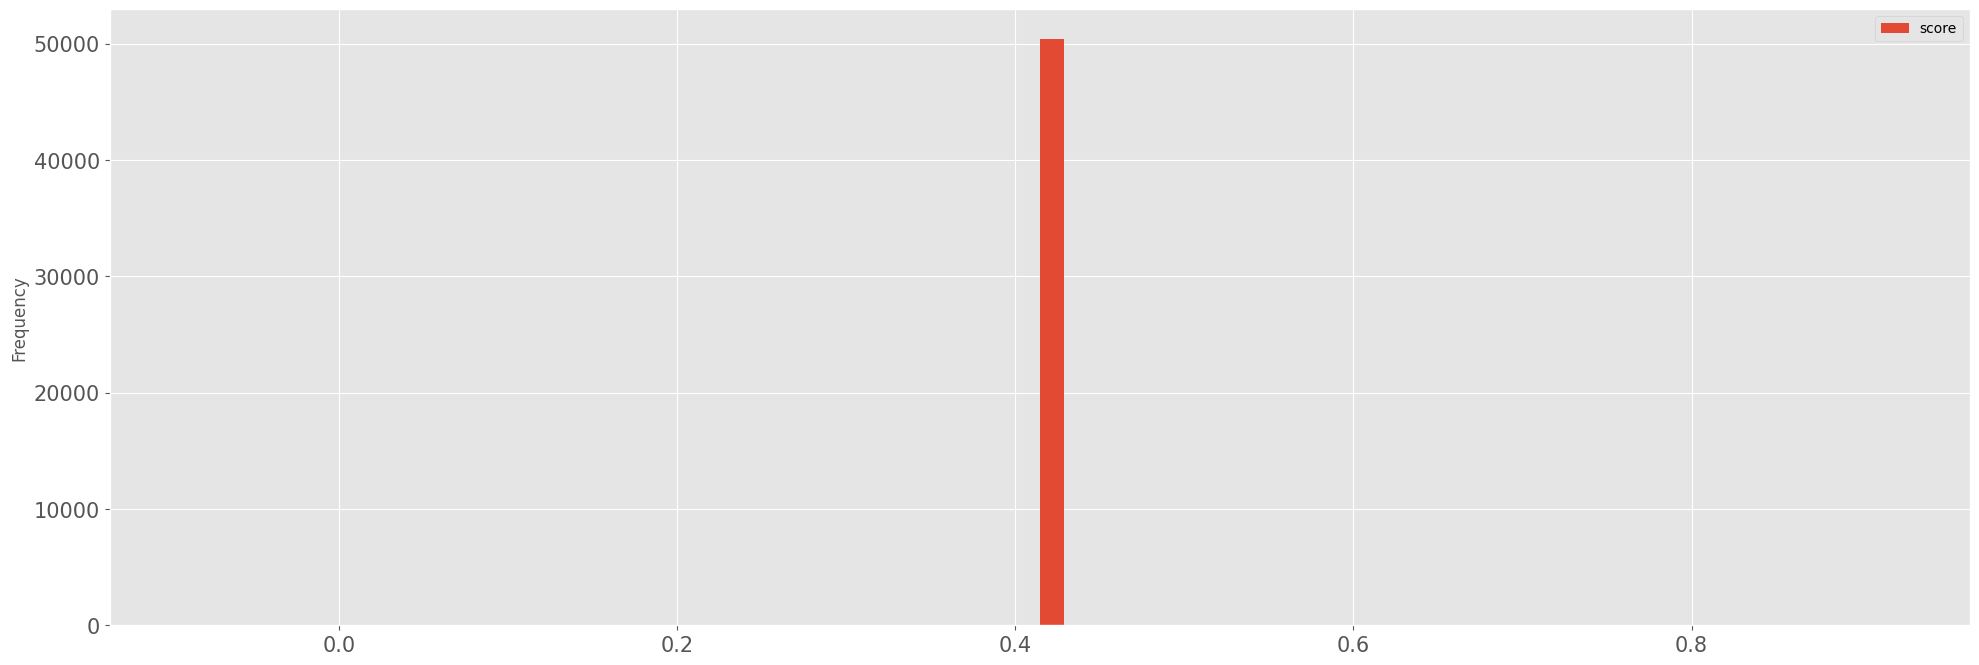

In [ ]:
plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(24,8))
score_pd = linkage.select('score').sample(False, 0.99, 42).toPandas().apply(pd.to_numeric)
score_pd.plot(kind='hist',ax=ax,bins=70,fontsize=15)
plt.show()

In [ ]:
inconsistent_scores = linkage.filter((F.col('score') > 1) | (F.col('score') < 0))

inconsistent_scores.show(100, False)

inconsistent_scores.groupBy('score').count().show()

+--------+-------+---------+--------+---------------+--------------+-------------+------------+------------+-----------+--------+-------+-----+
|seq_150k|seq_50k|name_150k|name_50k|mothername_150k|mothername_50k|municres_150k|municres_50k|dtbirth_150k|dtbirth_50k|sex_150k|sex_50k|score|
+--------+-------+---------+--------+---------------+--------------+-------------+------------+------------+-----------+--------+-------+-----+
+--------+-------+---------+--------+---------------+--------------+-------------+------------+------------+-----------+--------+-------+-----+

+-----+-----+
|score|count|
+-----+-----+
+-----+-----+



In [ ]:
name_columns = [col for col in linkage.columns if col.startswith('name')]
mothername_columns = [col for col in linkage.columns if col.startswith('mothername')]
dtbirth_columns = [col for col in linkage.columns if col.startswith('dtbirth')]
sex_columns = [col for col in linkage.columns if col.startswith('sex')]
codmunres_columns = [col for col in linkage.columns if col.startswith('municres')]

inconsistents_scores = linkage.filter(
    (F.col(name_columns[0]) == F.col(name_columns[1])) &
    (F.col(mothername_columns[0]) == F.col(mothername_columns[1])) &
    (F.col(dtbirth_columns[0]) == F.col(dtbirth_columns[1])) &
    (F.col(sex_columns[0]) == F.col(sex_columns[1])) &
    (F.col(codmunres_columns[0]) == F.col(codmunres_columns[1])) &
    (F.col('score') != 1)
)

INCONSISTENTS_SCORES_COUNT = inconsistents_scores.count()
print(f"Registros com todos atributos iguais, porém com score diferente de 1: {INCONSISTENTS_SCORES_COUNT}")
if INCONSISTENTS_SCORES_COUNT > 0: cidacs.show(inconsistents_scores)

Registros com todos atributos iguais, porém com score diferente de 1: 0


In [ ]:
inconsistents_scores = linkage.filter(
    (
        (F.col(name_columns[0]) != F.col(name_columns[1])) |
        (F.col(mothername_columns[0]) != F.col(mothername_columns[1])) |
        (F.col(dtbirth_columns[0]) != F.col(dtbirth_columns[1])) |
        (F.col(sex_columns[0]) != F.col(sex_columns[1])) |
        (F.col(codmunres_columns[0]) != F.col(codmunres_columns[1]))
    ) & (F.col('score') == 1)
)

INCONSISTENTS_SCORES_COUNT = inconsistents_scores.count()
print(f"Registros com atributos diferentes, porém score igual a 1: {INCONSISTENTS_SCORES_COUNT}")
if INCONSISTENTS_SCORES_COUNT > 0: cidacs.show(inconsistents_scores)

Registros com atributos diferentes, porém score igual a 1: 0


# **DATAMART COM LINKADOS**